In [1]:
!pip install keras

In [2]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
License(s): unknown
 96% 311M/325M [00:01<00:00, 183MB/s]
100% 325M/325M [00:01<00:00, 188MB/s]


In [4]:
from zipfile import ZipFile
with ZipFile("/content/skin-cancer-malignant-vs-benign.zip", "r") as zipobj:
  zipobj.extractall()

In [5]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D,
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [6]:
directory_benign_train = '/content/train/benign/'
directory_malignant_train = '/content/train/malignant/'
directory_benign_test = '/content/test/benign/'
directory_malignant_test = '/content/test/malignant/'

In [7]:
read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))
img_benign_train = [read(os.path.join(directory_benign_train, filename)) for filename in os.listdir(directory_benign_train)]
img_malignant_train = [read(os.path.join(directory_malignant_train, filename)) for filename in os.listdir(directory_malignant_train)]
img_benign_test = [read(os.path.join(directory_benign_test, filename)) for filename in os.listdir(directory_benign_test)]
img_malignant_test = [read(os.path.join(directory_malignant_test, filename)) for filename in os.listdir(directory_malignant_test)]

In [8]:
X_benign_train = np.array(img_benign_train, dtype='uint8')
X_malignant_train = np.array(img_malignant_train, dtype='uint8')
X_benign_test = np.array(img_benign_test, dtype='uint8')
X_malignant_test = np.array(img_malignant_test, dtype='uint8')

In [9]:
y_benign_train = np.zeros(X_benign_train.shape[0])
y_malignant_train = np.ones(X_malignant_train.shape[0])
y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [10]:
X_train = np.concatenate((X_benign_train, X_malignant_train), axis=0)
y_train = np.concatenate((y_benign_train, y_malignant_train), axis=0)
X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

In [11]:
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_train = X_train[s1]
y_train = y_train[s1]
X_test = X_test[s2]
y_test = y_test[s2]

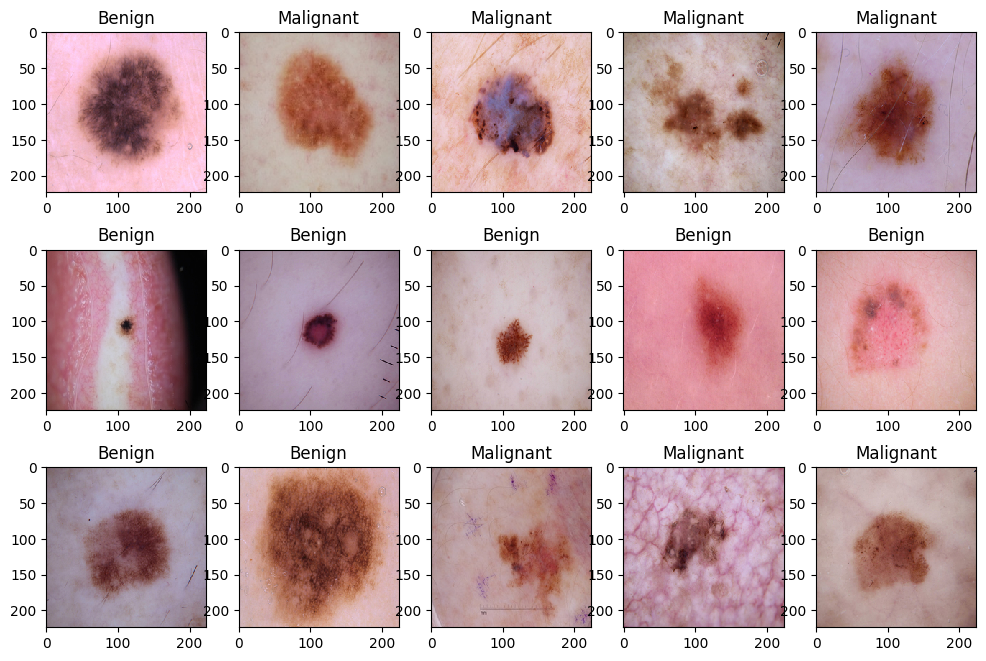

In [12]:
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 3

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [13]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [14]:
X_train = X_train/255
X_test = X_test/255

In [15]:
def build_cnn_model(input_shape = (224, 224, 3), num_classes=2):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', input_shape = input_shape, activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.summary()
    optimizer= Adam(lr=0.001)
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=["accuracy"])
    return model

model_cnn = build_cnn_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

In [16]:
learning_rate_annealer = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5, min_lr = 1e-7)
modelpath = "skin_cancer_detection.hdf5"
checkpoint = ModelCheckpoint(filepath=modelpath,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
history = model_cnn.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size = 64, verbose=1,callbacks=[learning_rate_annealer,checkpoint])

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 2.2635 - accuracy: 0.5367


Epoch 1: val_loss improved from inf to 0.68925, saving model to chest_xray_classifier.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 24s 458ms/step - loss: 2.2635 - accuracy: 0.5367 - val_loss: 0.6892 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5477


Epoch 2: val_loss improved from 0.68925 to 0.67568, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 11s 343ms/step - loss: 0.6817 - accuracy: 0.5477 - val_loss: 0.6757 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.6686


Epoch 3: val_loss did not improve from 0.67568
33/33 [==============================] - 10s 297ms/step - loss: 0.5956 - accuracy: 0.6686 - val_loss: 0.7771 - val_accuracy: 0.5795 - lr: 0.0010
Epoch 4/50
33/33 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.7577


Epoch 4: val_loss improved from 0.67568 to 0.62370, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 11s 323ms/step - loss: 0.4964 - accuracy: 0.7577 - val_loss: 0.6237 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/50
33/33 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.7933


Epoch 5: val_loss improved from 0.62370 to 0.60444, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 12s 361ms/step - loss: 0.4337 - accuracy: 0.7933 - val_loss: 0.6044 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/50
33/33 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.7895


Epoch 6: val_loss did not improve from 0.60444
33/33 [==============================] - 9s 281ms/step - loss: 0.4258 - accuracy: 0.7895 - val_loss: 0.6144 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 7/50
33/33 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.8046


Epoch 7: val_loss improved from 0.60444 to 0.59546, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 11s 333ms/step - loss: 0.4037 - accuracy: 0.8046 - val_loss: 0.5955 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 8/50
33/33 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.7971


Epoch 8: val_loss improved from 0.59546 to 0.48451, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 12s 354ms/step - loss: 0.3843 - accuracy: 0.7971 - val_loss: 0.4845 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 9/50
33/33 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.8189


Epoch 9: val_loss did not improve from 0.48451
33/33 [==============================] - 9s 278ms/step - loss: 0.3693 - accuracy: 0.8189 - val_loss: 0.6617 - val_accuracy: 0.7121 - lr: 0.0010
Epoch 10/50
33/33 [==============================] - ETA: 0s - loss: 0.3600 - accuracy: 0.8236


Epoch 10: val_loss did not improve from 0.48451
33/33 [==============================] - 9s 282ms/step - loss: 0.3600 - accuracy: 0.8236 - val_loss: 0.7158 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 11/50
33/33 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8198


Epoch 11: val_loss improved from 0.48451 to 0.46925, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 14s 437ms/step - loss: 0.3667 - accuracy: 0.8198 - val_loss: 0.4693 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 12/50
33/33 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8345


Epoch 12: val_loss did not improve from 0.46925
33/33 [==============================] - 9s 280ms/step - loss: 0.3418 - accuracy: 0.8345 - val_loss: 0.4774 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 13/50
33/33 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8369


Epoch 13: val_loss did not improve from 0.46925
33/33 [==============================] - 10s 290ms/step - loss: 0.3264 - accuracy: 0.8369 - val_loss: 0.5601 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 14/50
33/33 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8364


Epoch 14: val_loss improved from 0.46925 to 0.45514, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 15s 448ms/step - loss: 0.3256 - accuracy: 0.8364 - val_loss: 0.4551 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 15/50
33/33 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8464


Epoch 15: val_loss did not improve from 0.45514
33/33 [==============================] - 9s 280ms/step - loss: 0.3024 - accuracy: 0.8464 - val_loss: 0.4557 - val_accuracy: 0.7311 - lr: 0.0010
Epoch 16/50
33/33 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8625


Epoch 16: val_loss did not improve from 0.45514
33/33 [==============================] - 9s 285ms/step - loss: 0.3001 - accuracy: 0.8625 - val_loss: 0.5010 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 17/50
33/33 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8720


Epoch 17: val_loss improved from 0.45514 to 0.42123, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 15s 450ms/step - loss: 0.2736 - accuracy: 0.8720 - val_loss: 0.4212 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 18/50
33/33 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8729


Epoch 18: val_loss improved from 0.42123 to 0.40943, saving model to chest_xray_classifier.hdf5
33/33 [==============================] - 15s 460ms/step - loss: 0.2623 - accuracy: 0.8729 - val_loss: 0.4094 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 19/50
33/33 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.8909


Epoch 19: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 278ms/step - loss: 0.2370 - accuracy: 0.8909 - val_loss: 0.4218 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 20/50
33/33 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9071


Epoch 20: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 285ms/step - loss: 0.2083 - accuracy: 0.9071 - val_loss: 0.4365 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 21/50
33/33 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9128


Epoch 21: val_loss did not improve from 0.40943
33/33 [==============================] - 10s 289ms/step - loss: 0.2049 - accuracy: 0.9128 - val_loss: 0.5105 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 22/50
33/33 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9156


Epoch 22: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 282ms/step - loss: 0.1929 - accuracy: 0.9156 - val_loss: 0.4575 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 23/50
33/33 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9303


Epoch 23: val_loss did not improve from 0.40943
33/33 [==============================] - 10s 291ms/step - loss: 0.1676 - accuracy: 0.9303 - val_loss: 0.4249 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 24/50
33/33 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9308


Epoch 24: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 282ms/step - loss: 0.1620 - accuracy: 0.9308 - val_loss: 0.5030 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 25/50
33/33 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9374


Epoch 25: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 280ms/step - loss: 0.1634 - accuracy: 0.9374 - val_loss: 0.6127 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 26/50
33/33 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9265


Epoch 26: val_loss did not improve from 0.40943
33/33 [==============================] - 10s 289ms/step - loss: 0.1792 - accuracy: 0.9265 - val_loss: 0.5105 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 27/50
33/33 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9355


Epoch 27: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 288ms/step - loss: 0.1573 - accuracy: 0.9355 - val_loss: 0.5426 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 28/50
33/33 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9497


Epoch 28: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 281ms/step - loss: 0.1262 - accuracy: 0.9497 - val_loss: 0.5190 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 29/50
33/33 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9526


Epoch 29: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 281ms/step - loss: 0.1174 - accuracy: 0.9526 - val_loss: 0.5658 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 30/50
33/33 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9398


Epoch 30: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 287ms/step - loss: 0.1431 - accuracy: 0.9398 - val_loss: 0.5563 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 31/50
33/33 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9564


Epoch 31: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 288ms/step - loss: 0.1132 - accuracy: 0.9564 - val_loss: 0.6346 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 32/50
33/33 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9706


Epoch 32: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 280ms/step - loss: 0.0864 - accuracy: 0.9706 - val_loss: 0.5990 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 33/50
33/33 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9739


Epoch 33: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 287ms/step - loss: 0.0678 - accuracy: 0.9739 - val_loss: 0.6872 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 34/50
33/33 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9810


Epoch 34: val_loss did not improve from 0.40943
33/33 [==============================] - 10s 289ms/step - loss: 0.0614 - accuracy: 0.9810 - val_loss: 0.6931 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 35/50
33/33 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9711


Epoch 35: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 282ms/step - loss: 0.0708 - accuracy: 0.9711 - val_loss: 0.6437 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 36/50
33/33 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9763


Epoch 36: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 282ms/step - loss: 0.0709 - accuracy: 0.9763 - val_loss: 0.6899 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 37/50
33/33 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9763


Epoch 37: val_loss did not improve from 0.40943
33/33 [==============================] - 10s 289ms/step - loss: 0.0728 - accuracy: 0.9763 - val_loss: 0.7816 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 38/50
33/33 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9834


Epoch 38: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 287ms/step - loss: 0.0532 - accuracy: 0.9834 - val_loss: 0.6812 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 39/50
33/33 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9825


Epoch 39: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 280ms/step - loss: 0.0459 - accuracy: 0.9825 - val_loss: 0.7287 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 40/50
33/33 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9877


Epoch 40: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 282ms/step - loss: 0.0424 - accuracy: 0.9877 - val_loss: 0.7382 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 41/50
33/33 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9554


Epoch 41: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 278ms/step - loss: 0.1361 - accuracy: 0.9554 - val_loss: 0.6921 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 42/50
33/33 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9730


Epoch 42: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 282ms/step - loss: 0.0752 - accuracy: 0.9730 - val_loss: 0.6837 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 43/50
33/33 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9872


Epoch 43: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 276ms/step - loss: 0.0435 - accuracy: 0.9872 - val_loss: 0.9058 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 44/50
33/33 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9886


Epoch 44: val_loss did not improve from 0.40943
33/33 [==============================] - 10s 289ms/step - loss: 0.0405 - accuracy: 0.9886 - val_loss: 0.8748 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 45/50
33/33 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9716


Epoch 45: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 287ms/step - loss: 0.0907 - accuracy: 0.9716 - val_loss: 0.7526 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 46/50
33/33 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9649


Epoch 46: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 284ms/step - loss: 0.0910 - accuracy: 0.9649 - val_loss: 0.6371 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 47/50
33/33 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9900


Epoch 47: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 287ms/step - loss: 0.0442 - accuracy: 0.9900 - val_loss: 0.7630 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 48/50
33/33 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9943


Epoch 48: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 279ms/step - loss: 0.0238 - accuracy: 0.9943 - val_loss: 0.8272 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 49/50
33/33 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9900


Epoch 49: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 286ms/step - loss: 0.0431 - accuracy: 0.9900 - val_loss: 0.9590 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 50/50
33/33 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9877


Epoch 50: val_loss did not improve from 0.40943
33/33 [==============================] - 9s 286ms/step - loss: 0.0382 - accuracy: 0.9877 - val_loss: 0.9109 - val_accuracy: 0.8030 - lr: 0.0010


In [17]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model_cnn.predict(X_test), axis=-1)
print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

21/21 [==============================] - 2s 39ms/step
0.803030303030303


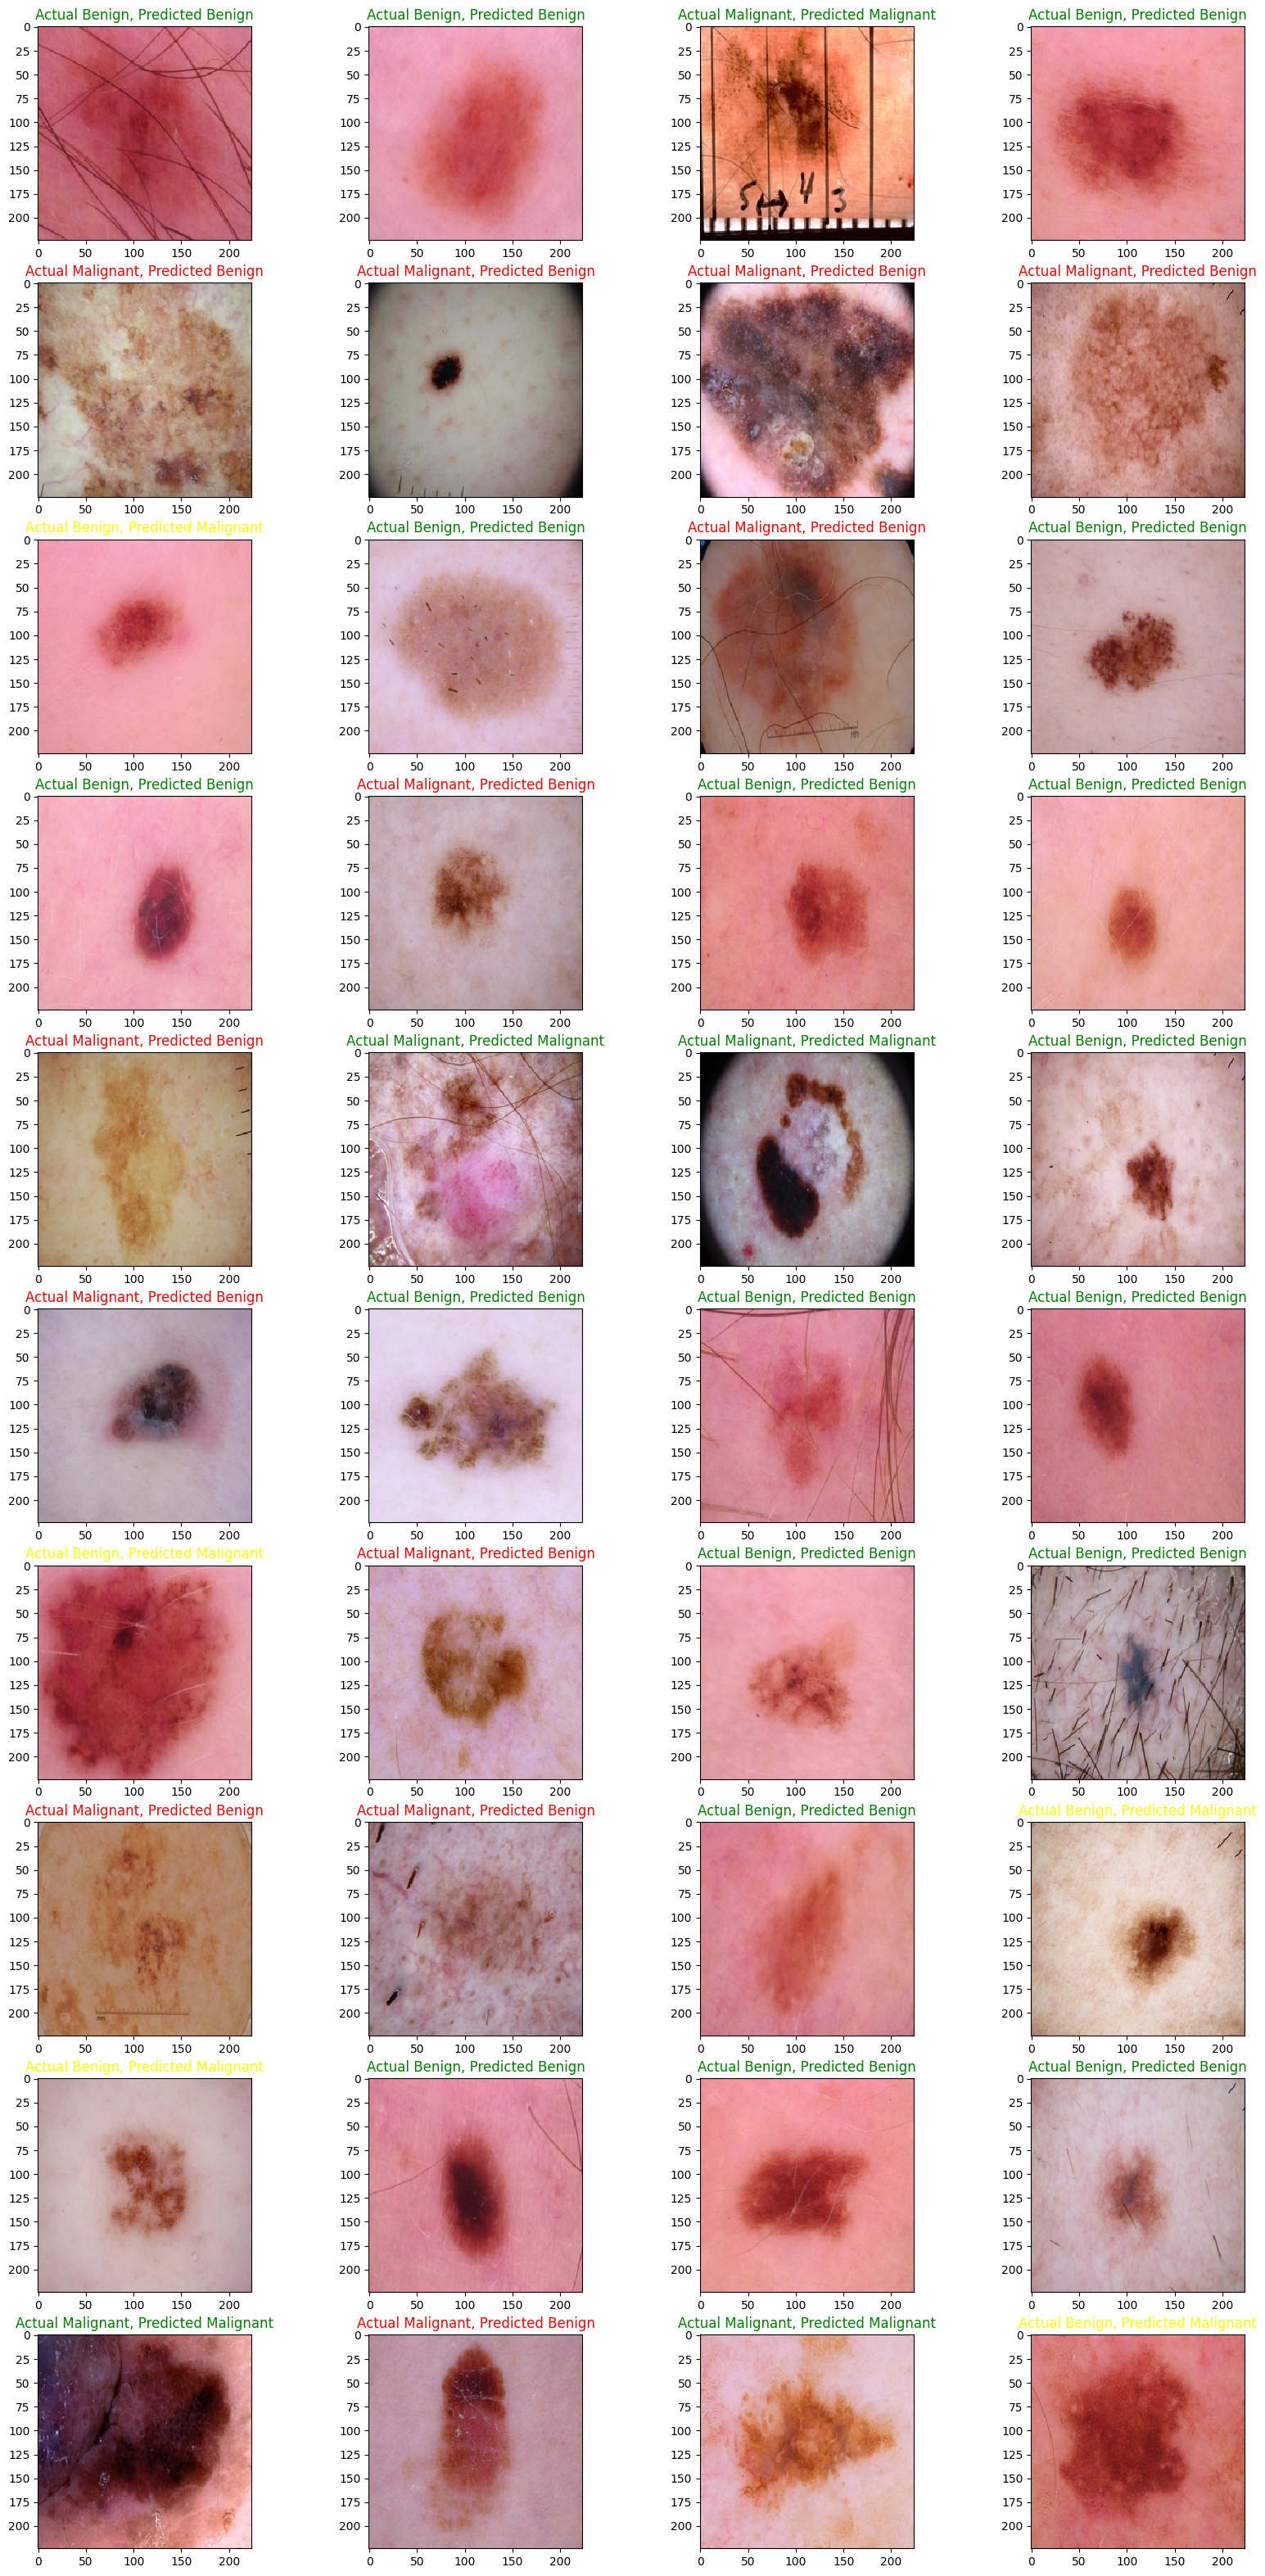

In [18]:
X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)
s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]
y_pred = y_pred[s2]
fig = plt.figure(figsize=(20,40))
columns = 4
rows = 10

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_test[i] == 0:
        if y_pred[i] == 0:
            ax.set_title('Actual Benign, Predicted Benign', color='green')
        else:
            ax.set_title('Actual Benign, Predicted Malignant', color='yellow')
    else:
        if y_pred[i] == 1:
            ax.set_title('Actual Malignant, Predicted Malignant', color='green')
        else:
            ax.set_title('Actual Malignant, Predicted Benign', color='red')


    plt.imshow(X_test[i], interpolation='nearest')
plt.show()

In [19]:
!pip install tensorflowjs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
  Attempting uninstall: ml-dtypes
    

In [2]:
!tensorflowjs_converter --input_format=keras /content/skin-cancer-detection.hdf5 /content/skin-cancer-detection

2024-05-05 10:29:22.682537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 10:29:24.714084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
!zip -r /content/file.zip /content/skin-cancer-detection/

  adding: content/skin-cancer-detection/ (stored 0%)
  adding: content/skin-cancer-detection/model.json (deflated 80%)
  adding: content/skin-cancer-detection/group1-shard9of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard2of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard3of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard1of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard16of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard6of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard25of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard14of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard23of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard22of25.bin (deflated 7%)
  adding: content/skin-cancer-detection/group1-shard18of25.bin (deflated 7%)
  adding: content/skin-cancer-detection

In [5]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>